# UntappdML

Project to export personal beer history from Untappd and try to apply a machine learning model to predict if you like a new beer or not.

### import

In [123]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import style
import re
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from joblib import dump, load

### load personal untappd beer history

You must be a supporter to be able to export beer history. Here we use the CSV format.

In [124]:
history = pd.read_csv("untappd.csv")

In [125]:
history.head(3)

,beer_name,brewery_name,beer_type,beer_abv,beer_ibu,comment,venue_name,venue_city,venue_state,venue_country,...,serving_type,checkin_id,bid,brewery_id,photo_url,global_rating_score,global_weighted_rating_score,tagged_friends,total_toasts,total_comments
0,Karhu III,Sinebrychoff,Lager - Pale,4.6,16,NaN,Espoo,NaN,Southern Finland,Suomi,...,NaN,216046681,39540,961,NaN,2.79,2.80,NaN,0,0
1,Libertine Black Ale,BrewDog,IPA - Black / Cascadian Dark Ale,7.2,65,NaN,Espoo,NaN,Southern Finland,Suomi,...,NaN,216049913,158573,241,https://untappd.s3.amazonaws.com/photo/2015_08...,3.80,3.80,NaN,0,0
2,Punk IPA,BrewDog,IPA - American,5.2,35,NaN,Espoo,NaN,Southern Finland,Suomi,...,NaN,216256060,5702,241,NaN,3.75,3.75,NaN,0,0


### drop unwanted columns

Ignore columns which won't make sense in the prediction.

In [126]:
history.columns

Index(['beer_name', 'brewery_name', 'beer_type', 'beer_abv', 'beer_ibu',
       'comment', 'venue_name', 'venue_city', 'venue_state', 'venue_country',
       'venue_lat', 'venue_lng', 'rating_score', 'created_at', 'checkin_url',
       'beer_url', 'brewery_url', 'brewery_country', 'brewery_city',
       'brewery_state', 'flavor_profiles', 'purchase_venue', 'serving_type',
       'checkin_id', 'bid', 'brewery_id', 'photo_url', 'global_rating_score',
       'global_weighted_rating_score', 'tagged_friends', 'total_toasts',
       'total_comments'],
      dtype='object')

In [127]:
history = history[[
    "beer_type",
    "beer_abv",
    "beer_ibu",
    "rating_score",
    "brewery_country",
    "global_rating_score"
]]

In [128]:
history.head(3)

,beer_type,beer_abv,beer_ibu,rating_score,brewery_country,global_rating_score
0,Lager - Pale,4.6,16,2.0,Finland,2.79
1,IPA - Black / Cascadian Dark Ale,7.2,65,4.5,Scotland,3.80
2,IPA - American,5.2,35,4.0,Scotland,3.75


### feature: beer type

In [129]:
history[["beer_type"]].value_counts()

beer_type                        
IPA - American                       301
Pale Ale - American                  148
IPA - Imperial / Double              105
IPA - New England                     84
IPA - Session / India Session Ale     82
                                    ... 
Farmhouse Ale - Bière de Garde         1
Specialty Grain                        1
English Mild Ale                       1
Cream Ale                              1
Australian Sparkling Ale               1
Length: 164, dtype: int64

In [130]:
history.loc[history.beer_type.str.contains("ipa", flags=re.IGNORECASE), "beer_type"] = "0"
history.loc[history.beer_type.str.contains("lager", flags=re.IGNORECASE)| history.beer_type.str.contains("pilsner", flags=re.IGNORECASE), "beer_type"] = "1"
history.loc[history.beer_type.str.contains("stout", flags=re.IGNORECASE), "beer_type"] = "2"
history.loc[history.beer_type.str.contains("pale ale", flags=re.IGNORECASE), "beer_type"] = "3"
history.loc[history.beer_type.str.contains("wheat", flags=re.IGNORECASE) | history.beer_type.str.contains("hefe", flags=re.IGNORECASE) | history.beer_type.str.contains("weizen", flags=re.IGNORECASE), "beer_type"] = "4"
history.loc[history.beer_type.str.contains("porter", flags=re.IGNORECASE), "beer_type"] = "5"
history.loc[history.beer_type.str.contains("sour", flags=re.IGNORECASE), "beer_type"] = "6"
history.loc[history.beer_type.str.contains("fruit", flags=re.IGNORECASE), "beer_type"] = "7"
history.loc[~history.beer_type.str.contains("0|1|2|3|4|5|6|7"), "beer_type"] = "8"
history["beer_type"] = history["beer_type"].astype(int)

<AxesSubplot:xlabel='beer_type', ylabel='Count'>

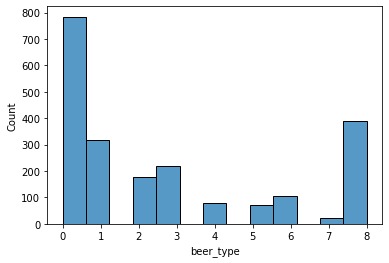

In [131]:
sns.histplot(data=history, x="beer_type")

### feature: beer abv

<AxesSubplot:xlabel='beer_abv', ylabel='Count'>

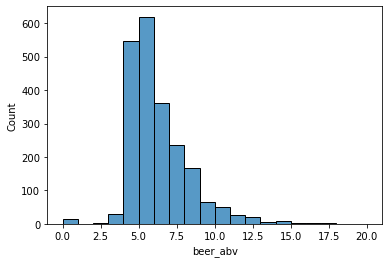

In [132]:
sns.histplot(data=history, x="beer_abv", bins=20)

In [133]:
history.loc[history["beer_abv"] <= 4.5, "beer_abv"] = 0
history.loc[(history["beer_abv"] > 4.5) & (history["beer_abv"] <= 5), "beer_abv"] = 1
history.loc[(history["beer_abv"] > 5) & (history["beer_abv"] <= 5.5), "beer_abv"] = 2
history.loc[(history["beer_abv"] > 5.5) & (history["beer_abv"] <= 6), "beer_abv"] = 3
history.loc[(history["beer_abv"] > 6) & (history["beer_abv"] <= 7), "beer_abv"] = 4
history.loc[(history["beer_abv"] > 7) & (history["beer_abv"] <= 8), "beer_abv"] = 5
history.loc[history["beer_abv"] > 8, "beer_abv"] = 6
history["beer_abv"] = history["beer_abv"].astype(int)

<AxesSubplot:xlabel='beer_abv', ylabel='Count'>

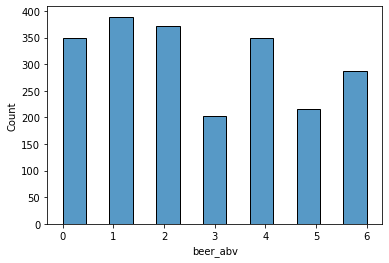

In [134]:
sns.histplot(data=history, x="beer_abv")

### feature: beer ibu

<AxesSubplot:xlabel='beer_ibu', ylabel='Count'>

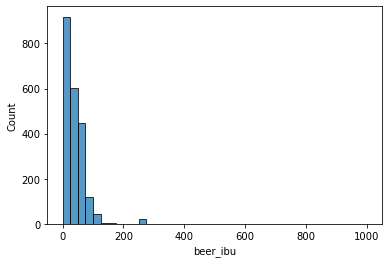

In [135]:
sns.histplot(data=history, x="beer_ibu", bins=40)

In [136]:
history.loc[history["beer_ibu"] == 0, "beer_ibu"] = 0
history.loc[(history["beer_ibu"] > 0) & (history["beer_ibu"] <= 20), "beer_ibu"] = 1
history.loc[(history["beer_ibu"] > 20) & (history["beer_ibu"] <= 30), "beer_ibu"] = 2
history.loc[(history["beer_ibu"] > 30) & (history["beer_ibu"] <= 40), "beer_ibu"] = 3
history.loc[(history["beer_ibu"] > 40) & (history["beer_ibu"] <= 60), "beer_ibu"] = 4
history.loc[(history["beer_ibu"] > 60) & (history["beer_ibu"] <= 80), "beer_ibu"] = 5
history.loc[history["beer_ibu"] > 80, "beer_ibu"] = 6
history["beer_ibu"] = history["beer_ibu"].astype(int)

<AxesSubplot:xlabel='beer_ibu', ylabel='Count'>

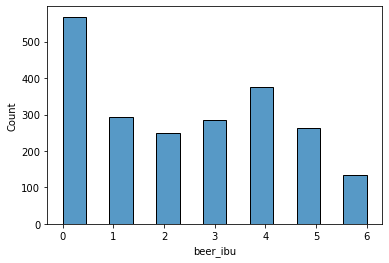

In [137]:
sns.histplot(data=history, x="beer_ibu")

### feature: brewery country

In [138]:
history[["brewery_country"]].value_counts()

brewery_country                   
Finland                               787
United States                         280
England                               207
Scotland                              187
Estonia                               111
Sweden                                100
Germany                                77
Denmark                                70
Belgium                                59
Netherlands                            47
Norway                                 42
Spain                                  23
Czech Republic                         22
Ireland                                20
France                                 14
Aland Islands                          14
Japan                                  12
Poland                                 11
Italy                                  10
Mexico                                  9
Iceland                                 8
Canada                                  8
Russia                                  8

In [139]:
history.loc[history.brewery_country.str.contains("united states|canada", flags=re.IGNORECASE), "brewery_country"] = "0"
history.loc[history.brewery_country.str.contains("scotland|united kingdom|wales", flags=re.IGNORECASE), "brewery_country"] = "1"
history.loc[history.brewery_country.str.contains("germany|austria", flags=re.IGNORECASE), "brewery_country"] = "2"
history.loc[history.brewery_country.str.contains("finland|sweden|norway|denmark|iceland", flags=re.IGNORECASE), "brewery_country"] = "3"
history.loc[history.brewery_country.str.contains("belgium|france|netherlands", flags=re.IGNORECASE), "brewery_country"] = "4"
history.loc[history.brewery_country.str.contains("czech republic|slovakia", flags=re.IGNORECASE), "brewery_country"] = "5"
history.loc[~history.brewery_country.str.contains("0|1|2|3|4|5"), "brewery_country"] = "6"
history["brewery_country"] = history["brewery_country"].astype(int)

<AxesSubplot:xlabel='brewery_country', ylabel='Count'>

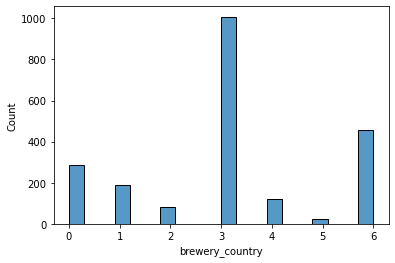

In [140]:
sns.histplot(data=history, x="brewery_country")

### drop nulls

In [141]:
history = history.dropna()

### label: rating score

This is what we want to predict. Take the mean of all personal ratings, and apply a label of "like" if above or equal to the mean, and "not like" if below.

In [142]:
m = history["rating_score"].mean(axis=0)

In [143]:
m

3.399930426716141

In [144]:
history.loc[history["rating_score"] < m, "rating_score"] = 0
history.loc[history["rating_score"] >= m, "rating_score"] = 1
history["rating_score"] = history["rating_score"].astype(int)

<AxesSubplot:xlabel='rating_score', ylabel='Count'>

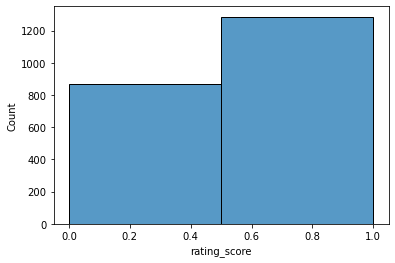

In [145]:
sns.histplot(data=history, x="rating_score", bins=2)

### train/test split

Split the entire history into a traing and testing data set.

In [146]:
x = history.drop("rating_score", axis=1)
y = history[["rating_score"]]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

### random forest

In [147]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(x_train, y_train)

<ipython-input-147-ff409dd62e95>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  random_forest.fit(x_train, y_train)


RandomForestClassifier()

In [148]:
y_pred = random_forest.predict(x_test)

In [149]:
random_forest.score(x_train, y_train)
acc_random_forest = round(random_forest.score(x_train, y_train) * 100, 2)

In [150]:
acc_random_forest

98.96

### feature importance

In [151]:
importances = pd.DataFrame({"feature": x_train.columns, "importance": np.round(random_forest.feature_importances_, 3)})
importances = importances.sort_values("importance", ascending=False).set_index("feature")
importances.head(15)

,importance
feature,
global_rating_score,0.558
beer_type,0.155
beer_abv,0.139
beer_ibu,0.083
brewery_country,0.065


<AxesSubplot:xlabel='feature'>

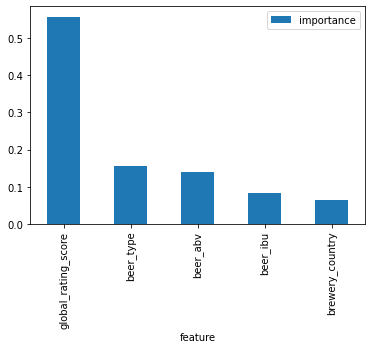

In [152]:
importances.plot.bar()

### precision and recall

In [88]:
predictions = cross_val_predict(random_forest, x_train, y_train, cv=3)
confusion_matrix(y_train, predictions)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:862: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:862: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:862: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


array([[584, 111],
       [102, 927]])

In [89]:
print("Precision:", precision_score(y_train, predictions))
print("Recall:",recall_score(y_train, predictions))

Precision: 0.8930635838150289
Recall: 0.9008746355685131


### f1-score

In [90]:
f1_score(y_train, predictions)

0.8969521044992743

### persist model

In [91]:
dump(random_forest, "random_forest.joblib")

['random_forest.joblib']